# Lab 3: KNN and Decision Trees


In this lab we'll get some hands on experience with two of the classifiers we've seen in class
- K Nearest Neighbors
- Decision Trees

## Goals for this lab

- Understand the practical implications for changing the parameters used in KNearest Neighbor Classifier
  - k
  - distance metric
  - weighting method
  
  
- Understand the practical implications for changing the parameters used in Decision Trees

 - splitting criteria (gini vs information gain)
 - max depth
 - min sample size for split
 
- Understand how to interpret Decision Trees

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.tree as tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import graphviz # If you don't have this, install via pip/conda
%matplotlib inline

# Data
We'll use these classifiers on a small dataset on world happiness metrics:
https://www.kaggle.com/unsdsn/world-happiness/

Download the data from 2015 or 2016 and load it. Note: the 2017 data is missing the Region column so don't use that.

You should also try this with other data sets you have been provided for the homeworks.

In [314]:
# Change this to wherever you're storing your data
dfile = '2015.csv'
df = pd.read_csv(dfile)

In [315]:
df.head()

Country          Region  Happiness Rank  Happiness Score  \
0  Switzerland  Western Europe               1            7.587   
1      Iceland  Western Europe               2            7.561   
2      Denmark  Western Europe               3            7.527   
3       Norway  Western Europe               4            7.522   
4       Canada   North America               5            7.427   

   Standard Error  Economy (GDP per Capita)   Family  \
0         0.03411                   1.39651  1.34951   
1         0.04884                   1.30232  1.40223   
2         0.03328                   1.32548  1.36058   
3         0.03880                   1.45900  1.33095   
4         0.03553                   1.32629  1.32261   

   Health (Life Expectancy)  Freedom  Trust (Government Corruption)  \
0                   0.94143  0.66557                        0.41978   
1                   0.94784  0.62877                        0.14145   
2                   0.87464  0.64938                        0.48357   
3                   0.88521  0.66973                        0.36503   
4                   0.90563  0.63297                        0.32957   

   Generosity  Dystopia Residual  
0     0.29678            2.51738  
1     0.43630            2.70201  
2     0.34139            2.49204  
3     0.34699            2.46531  
4     0.45811            2.45176

# Some Quick Data Exploration
Before running any sort of model on your dataset, it's always a good idea to do some quick data exploration to get a sense of how your data looks like. Try to answer the following questions with some sort of plot/histogram/etc:

1) What do the distributions of each feature look like?

In [311]:
def plot_hist(variable):
    plt.hist(df[variable], bins=20)
    plt.title('Distribution of'+ ' '+  variable)
    plt.ylabel(variable)
    plt.xlabel('Frequency')
    plt.show()

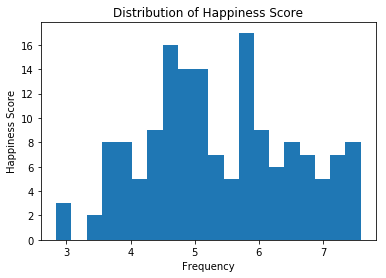

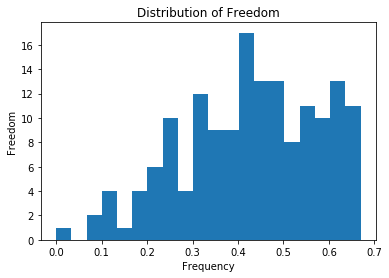

In [312]:
plot_hist('Happiness Score')
plot_hist('Freedom')

2) Do countries from the same region have similar feature values? (To save on time so that you're not generating hundreds of plots, you can just pick one or two regions, and look at whichever features look most interesting).

Hint: consider using [pandas' groupby function](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html) or doing a manual filter

In [319]:
by_region= df.groupby(['Region'])['Happiness Score'].mean()

In [320]:
by_region.head()

Region
Australia and New Zealand          7.285000
Central and Eastern Europe         5.332931
Eastern Asia                       5.626167
Latin America and Caribbean        6.144682
Middle East and Northern Africa    5.406900
Name: Happiness Score, dtype: float64

3) Which features are least correlated with "Happiness"?

Hint: Plotting this is a good idea. Also consider using [pandas' correlation function](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.corr.html)

In [321]:
# Example plot
def scatterplot(var_y,var_x):
    plt.scatter(df[var_y], df[var_x])
    plt.title(var_y +' '+ 'vs'+ ' '+ var_x)
    plt.xlabel(var_x) # units unclear...
    plt.ylabel(var_y)
    plt.show()

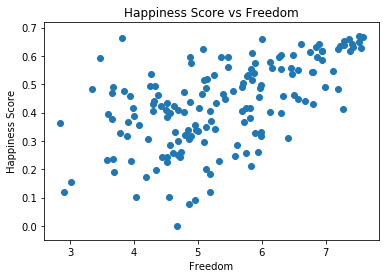

In [322]:
scatterplot('Happiness Score', 'Freedom')

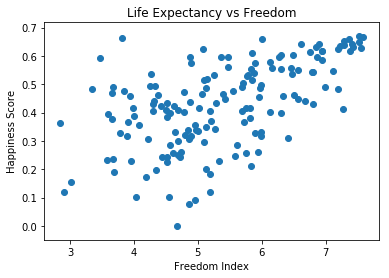

In [8]:
# Example plot
plt.scatter(df['Happiness Score'], df['Freedom'])
plt.title('Life Expectancy vs Freedom')
plt.xlabel('Freedom Index') # units unclear...
plt.ylabel('Happiness Score')
plt.show()

## Classification
A natural thing to do with this dataset is to try to use the various feature columns to predict each country's "Happiness Score" via some regression model. But in this class we're mostly going to focus on classification. So let's create a toy column so that we have a classification task: create a binary 'In Europe' column. We can do this by checking if "Europe" is contained in the "Region" column of each row.

In [323]:
df['In Europe'] = df['Region'].apply(lambda x: 'Europe' in x)

Before we can use any of the classifiers, we need to pick which features we want to drop/keep.

In [324]:
df.drop(['Region', 'Happiness Rank'], axis=1, inplace=True)
df.head()

Country  Happiness Score  Standard Error  Economy (GDP per Capita)  \
0  Switzerland            7.587         0.03411                   1.39651   
1      Iceland            7.561         0.04884                   1.30232   
2      Denmark            7.527         0.03328                   1.32548   
3       Norway            7.522         0.03880                   1.45900   
4       Canada            7.427         0.03553                   1.32629   

    Family  Health (Life Expectancy)  Freedom  Trust (Government Corruption)  \
0  1.34951                   0.94143  0.66557                        0.41978   
1  1.40223                   0.94784  0.62877                        0.14145   
2  1.36058                   0.87464  0.64938                        0.48357   
3  1.33095                   0.88521  0.66973                        0.36503   
4  1.32261                   0.90563  0.63297                        0.32957   

   Generosity  Dystopia Residual  In Europe  
0     0.29678            2.51738       True  
1     0.43630            2.70201       True  
2     0.34139            2.49204       True  
3     0.34699            2.46531       True  
4     0.45811            2.45176      False

# Train/Test Splits

Create a train/test set split using sklearn's [train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function. We'll use these train/test splits for evaluating all our classification models.

In [325]:
countries = df['Country'] # useful later for reindexing
X = df.drop(['In Europe', 'Country'], axis=1)
Y = df['In Europe']
test_size = 0.3 # you can adjust this
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=test_size)

In [14]:
# If your metric has a metric parameter you need to pass that in via a
# dictionary to metric_params.
knn = KNeighborsClassifier(n_neighbors=10, metric='minkowski', metric_params={'p': 3})

/Users/aleistermontfort/anaconda3/envs/py35/lib/python3.6/site-packages/ipykernel_launcher.py:3: SyntaxWarning: Parameter p is found in metric_params. The corresponding parameter from __init__ is ignored.
  This is separate from the ipykernel package so we can avoid doing imports until


Remember that when training a model, **you should only use the training data!** The test set is reserved exclusively for evaluating your model. Now let's use the classifier:

In [348]:
knn = KNeighborsClassifier(n_neighbors=10, metric='minkowski', weights = 'distance')
knn.fit(x_train, y_train)
knn.predict(x_test)

array([False,  True,  True,  True,  True, False, False,  True,  True,
        True, False, False, False, False, False,  True,  True, False,
       False, False, False, False, False,  True, False, False, False,
        True, False, False, False, False,  True, False, False, False,
        True, False,  True, False,  True,  True,  True, False, False,
       False, False, False])

## KNN Tasks:

1) Write a function that computes the accuracy of the predicted values



In [62]:
from sklearn.metrics import accuracy_score

In [349]:
accuracy_score(y_test, knn.predict(x_test))

0.7708333333333334

In [110]:
def accuracy(test, data, column_name):
    
    pd.concat([data, test, axis=1, keys=[data.index, data.index])

In [ ]:
pd.concat([data, test, axis=1, keys=[data.index, data.index]))

2) Play around with the n_neighbors value. Fit your data on the training data(x_train, y_train). Then evaluate it on both the training data, and the testing data. How does the accuracy of your train and test set predictions change as you increase n_neighbors?


In [354]:
knn = KNeighborsClassifier(n_neighbors=10, metric='minkowski', weights = 'distance')
knn.fit(x_train, y_train)
knn.predict(x_test)

array([False,  True,  True,  True,  True, False, False,  True,  True,
        True, False, False, False, False, False,  True,  True, False,
       False, False, False, False, False,  True, False, False, False,
        True, False, False, False, False,  True, False, False, False,
        True, False,  True, False,  True,  True,  True, False, False,
       False, False, False])

In [355]:
accuracy_score(y_test, knn.predict(x_test))

0.7708333333333334

3) The KNeighborsClassifier also has a [predict_proba](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier.predict_proba) function. Which countries is the classifier most/least confident about?

In [356]:
knn.predict_proba(x_test)

array([[0.91063211, 0.08936789],
       [0.30883276, 0.69116724],
       [0.37043225, 0.62956775],
       [0.3908817 , 0.6091183 ],
       [0.2701081 , 0.7298919 ],
       [0.62355425, 0.37644575],
       [0.57833871, 0.42166129],
       [0.4332197 , 0.5667803 ],
       [0.48310244, 0.51689756],
       [0.39972776, 0.60027224],
       [0.63243974, 0.36756026],
       [0.61439395, 0.38560605],
       [0.88500811, 0.11499189],
       [0.68733847, 0.31266153],
       [0.60008722, 0.39991278],
       [0.30627927, 0.69372073],
       [0.25303917, 0.74696083],
       [0.68401159, 0.31598841],
       [0.5898034 , 0.4101966 ],
       [0.70199985, 0.29800015],
       [1.        , 0.        ],
       [0.86032471, 0.13967529],
       [0.5464278 , 0.4535722 ],
       [0.15143686, 0.84856314],
       [0.55347093, 0.44652907],
       [1.        , 0.        ],
       [0.55436137, 0.44563863],
       [0.29238005, 0.70761995],
       [0.6092346 , 0.3907654 ],
       [0.90234032, 0.09765968],
       [1.

4) You can see what datapoints are closest to a given query point via the [kneighbors function](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier.kneighbors). What countries are closest to Switzerland? United States? Your favorite country?

In [359]:

neighbors =pd.DataFrame(knn.kneighbors(x_test, 2, False))
neighbors.columns = ['neighbor_1', 'neighbor_2']
countrydf=pd.DataFrame(countries)

In [368]:
def add_neighbors(data_test, country_df, col_country, number_neighbors):
    neighbors =pd.DataFrame(knn.kneighbors(data_test, number_neighbors, False))
    names = []
    for element in range(number_neighbors):
        col = 'neighbor_'+ str(element + 1)
        names.append(col)
    neighbors.columns = names
    countrydf = pd.DataFrame(countries)
    neighbors.set_index(data_test.index, inplace = True)
    for column in names:
        neighbors[column] = neighbors[column].map(country_df[col_country])
    data_neighbors = data_test.join(country_df).join(neighbors)
    return data_neighbors

In [370]:
add_neighbors(x_test,countrydf,'Country', 3 ).head()

Happiness Score  Standard Error  Economy (GDP per Capita)   Family  \
121            4.512         0.03780                   0.19073  0.60406   
9              7.284         0.04083                   1.33358  1.30923   
44             5.995         0.04267                   1.16891  1.26999   
85             5.124         0.06607                   1.04345  0.88588   
102            4.839         0.04337                   1.02564  0.80001   

     Health (Life Expectancy)  Freedom  Trust (Government Corruption)  \
121                   0.44055  0.43450                        0.15048   
9                     0.93156  0.65124                        0.35637   
44                    0.78902  0.31751                        0.03431   
85                    0.76890  0.35068                        0.00649   
102                   0.83947  0.33916                        0.04582   

     Generosity  Dystopia Residual    Country          neighbor_1  \
121     0.24325            2.44876   Ethiopia             Vietnam   
9       0.43562            2.26646  Australia  Dominican Republic   
44      0.16893            2.24639   Slovakia            Colombia   
85      0.13748            1.93129    Romania           Mauritius   
102     0.21854            1.57059    Lebanon             Iceland   

       neighbor_2   neighbor_3  
121     Guatemala   Luxembourg  
9           Spain  New Zealand  
44        Lebanon      Germany  
85   North Cyprus      Bahrain  
102  North Cyprus         Peru

In [366]:
neighbors.set_index(x_test.index, inplace = True)
neighbors['neighbor_1']= neighbors['neighbor_1'].map(countrydf['Country'])
neighbors['neighbor_2']= neighbors['neighbor_2'].map(countrydf['Country'])



In [367]:
neighbors.head()

neighbor_1    neighbor_2
121             Vietnam     Guatemala
9    Dominican Republic         Spain
44             Colombia       Lebanon
85            Mauritius  North Cyprus
102             Iceland  North Cyprus

In [303]:
data_neighbors = x_test.join(countries).join(neighbors)
data_neighbors.head()

Happiness Score  Standard Error  Economy (GDP per Capita)   Family  \
91             5.013         0.03420                   0.73479  0.64095   
150            3.655         0.05141                   0.46534  0.77115   
74             5.360         0.03107                   0.63216  0.91226   
1              7.561         0.04884                   1.30232  1.40223   
37             6.298         0.03868                   1.29098  1.07617   

     Health (Life Expectancy)  Freedom  Trust (Government Corruption)  \
91                    0.60954  0.41691                        0.08546   
150                   0.15185  0.46866                        0.17922   
74                    0.74676  0.59444                        0.10441   
1                     0.94784  0.62877                        0.14145   
37                    0.87530  0.39740                        0.08129   

     Generosity  Dystopia Residual      Country               neighbor_1  \
91      0.07172            2.45373      Morocco              Netherlands   
150     0.20165            1.41723  Ivory Coast  Palestinian Territories   
74      0.16860            2.20173      Vietnam                 Mongolia   
1       0.43630            2.70201      Iceland     United Arab Emirates   
37      0.25376            2.32323       Taiwan                   Cyprus   

    neighbor_2  
91   Singapore  
150     Turkey  
74        Iran  
1         Laos  
37   Australia

5) Use a different metric for the KNN classifier. Evaluate the train/test set accuracies with the new KNN classifier.

In [372]:
knn = KNeighborsClassifier(n_neighbors=10, metric='manhattan', weights = 'distance')
knn.fit(x_train, y_train)
knn.predict(x_test)

array([False,  True,  True,  True,  True, False,  True,  True,  True,
        True, False, False, False, False, False,  True,  True, False,
       False, False, False, False, False,  True, False, False, False,
        True, False, False, False, False,  True, False, False, False,
        True, False,  True, False, False,  True,  True, False, False,
       False, False, False])

In [373]:
accuracy_score(y_test, knn.predict(x_test))

0.7291666666666666

In [374]:
# CODEknn = KNeighborsClassifier(n_neighbors=10, metric='minkowski', weights = 'distance')
knn.fit(x_train, y_train)
knn.predict(x_test)

accuracy_score(y_test, knn.predict(x_test))
 

0.7291666666666666

6) Use a different weighting function for the KNN classifier. Evaluate the train/test set accuracies with the new KNN classifier.

In [2]:
# CODE

## Now write a nested for loop that loops over all the parameters and values and store the results in a data frame

### pseudocode

- for k in 1,2,3,4,5...10
  - for distance metric in (metric1, metric2,...)
    - for weighting function in (uniform, distance weighted)
      - train model
      - score test data
      - evaluate - calculate metrics
      - store parameters and evaluation metric in data frame
- print dataframe


     

In [4]:
for k in len()

###  You cn now use this data frame to analyze the results and see how the model performs as you modify the parameters

# Decision Trees

Moving onto decision trees. The [DecisionTreeClassifier constructor](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier) can take a number of parameters. You should look at all the available 
- criterion: string, "gini' for Gini Impurity or 'entropy' for information gain
- splitter: string,  "best" or 'random'
- max_features: the number of features to consider when looking for the best split.
- max_depth: int, the maximum depth of the tree.
- min_samples_split: minimum number of samples required to split an internal node
- min_samples_leaf: min number of samples required to be at a leaf node.
- max_leaf_nodes: max number of leaf nodes a tree can have

We can do the same fit/predict/predict_proba:

In [394]:
dec_tree = DecisionTreeClassifier()
dec_tree.fit(x_train, y_train)
# dec_tree.predict(x_train)
# dec_tree.predict_proba(y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [378]:
dec_tree.predict(x_train)


array([ True,  True, False, False, False,  True, False,  True,  True,
       False, False, False, False,  True, False, False, False,  True,
       False, False,  True, False, False, False,  True,  True, False,
        True,  True, False, False,  True,  True, False, False,  True,
        True, False, False, False,  True,  True, False, False,  True,
        True, False, False, False, False,  True, False, False, False,
        True, False,  True,  True, False,  True, False,  True, False,
       False,  True,  True, False, False, False, False,  True,  True,
       False, False, False,  True, False, False, False, False, False,
        True, False, False, False, False,  True, False, False, False,
       False, False,  True,  True,  True, False, False, False, False,
       False, False, False,  True, False, False, False,  True, False,
       False, False])

We'll be interested in how each of these parameters will affect the performance of a Decision Tree classifier.

For example: Increasing max_depth this should increase your model's ability to explain the data and eventually overfit the training data once it's high enough. The performance on the test set should degrade a bit as the training set is overfitted.

In [379]:
from sklearn.metrics import accuracy_score as accuracy

In [382]:
depths = [1, 3, 5, 7, 9,]
for d in depths:
    dec_tree = DecisionTreeClassifier(max_depth=d)
    dec_tree.fit(x_train, y_train)
    train_pred = dec_tree.predict(x_train)
    test_pred = dec_tree.predict(x_test)
    # evaluate accuracy
    train_acc = accuracy(train_pred, y_train)
    test_acc = accuracy(test_pred, y_test)
    
    print("Depth: {} | Train acc: {:.2f} | Test acc: {:.2f}".format(d, train_acc, test_acc))

Depth: 1 | Train acc: 0.71 | Test acc: 0.58
Depth: 3 | Train acc: 0.87 | Test acc: 0.69
Depth: 5 | Train acc: 0.93 | Test acc: 0.62
Depth: 7 | Train acc: 0.98 | Test acc: 0.62
Depth: 9 | Train acc: 1.00 | Test acc: 0.65
Depth: 11 | Train acc: 1.00 | Test acc: 0.73


## Decision Tree Tasks
1) Repeat the above with each parameter in DecisionTreeClassifier. What range of values makes sense for each parameter?
(IE: does it make sense to have max_depth greater than 7 or 8 for this dataset?)

In [381]:
criterion = ['gini', 'entropy']
for crit in criterion:
    dec_tree = DecisionTreeClassifier(criterion=crit)
    dec_tree.fit(x_train, y_train)
    train_pred = dec_tree.predict(x_train)
    test_pred = dec_tree.predict(x_test)
    # evaluate accuracy
    train_acc = accuracy(train_pred, y_train)
    test_acc = accuracy(test_pred, y_test)
    
    print("Criterion: {} | Train acc: {:.2f} | Test acc: {:.2f}".format(crit, train_acc, test_acc))

Depth: gini | Train acc: 1.00 | Test acc: 0.73
Depth: entropy | Train acc: 1.00 | Test acc: 0.79


In [384]:
splitter = ['best', 'random']
for split in splitter:
    dec_tree = DecisionTreeClassifier(splitter=split)
    dec_tree.fit(x_train, y_train)
    train_pred = dec_tree.predict(x_train)
    test_pred = dec_tree.predict(x_test)
    # evaluate accuracy
    train_acc = accuracy(train_pred, y_train)
    test_acc = accuracy(test_pred, y_test)
    
    print("Splitter: {} | Train acc: {:.2f} | Test acc: {:.2f}".format(split, train_acc, test_acc))

Splitter: best | Train acc: 1.00 | Test acc: 0.67
Splitter: random | Train acc: 1.00 | Test acc: 0.75


In [406]:
max_features = [2,3,5,7]
for maxi in max_features:
    dec_tree = DecisionTreeClassifier(max_features = maxi)
    dec_tree.fit(x_train, y_train)
    train_pred = dec_tree.predict(x_train)
    test_pred = dec_tree.predict(x_test)
    # evaluate accuracy
    train_acc = accuracy(train_pred, y_train)
    test_acc = accuracy(test_pred, y_test)
    
    print("Max Features: {} | Train acc: {:.2f} | Test acc: {:.2f}".format(maxi, train_acc, test_acc))

Max Features: 2 | Train acc: 1.00 | Test acc: 0.75
Max Features: 3 | Train acc: 1.00 | Test acc: 0.77
Max Features: 5 | Train acc: 1.00 | Test acc: 0.75
Max Features: 7 | Train acc: 1.00 | Test acc: 0.62


In [389]:
max_depth = [2,3,5,7,9]
for maxi in max_depth:
    dec_tree = DecisionTreeClassifier(max_features = maxi)
    dec_tree.fit(x_train, y_train)
    train_pred = dec_tree.predict(x_train)
    test_pred = dec_tree.predict(x_test)
    # evaluate accuracy
    train_acc = accuracy(train_pred, y_train)
    test_acc = accuracy(test_pred, y_test)
    
    print("Max Depth: {} | Train acc: {:.2f} | Test acc: {:.2f}".format(maxi, train_acc, test_acc))

Max Depth: 2 | Train acc: 1.00 | Test acc: 0.75
Max Depth: 3 | Train acc: 1.00 | Test acc: 0.81
Max Depth: 5 | Train acc: 1.00 | Test acc: 0.77
Max Depth: 7 | Train acc: 1.00 | Test acc: 0.60
Max Depth: 9 | Train acc: 1.00 | Test acc: 0.62


In [164]:
min_samples_split

In [392]:
min_sample_l = [3,5,7,9]
for mini in min_sample_l:
    dec_tree = DecisionTreeClassifier(min_samples_leaf  = mini)
    dec_tree.fit(x_train, y_train)
    train_pred = dec_tree.predict(x_train)
    test_pred = dec_tree.predict(x_test)
    # evaluate accuracy
    train_acc = accuracy(train_pred, y_train)
    test_acc = accuracy(test_pred, y_test)
    
    print("Min Samples leaf: {} | Train acc: {:.2f} | Test acc: {:.2f}".format(mini, train_acc, test_acc))

Min Samples leaf: 3 | Train acc: 0.95 | Test acc: 0.71
Min Samples leaf: 5 | Train acc: 0.91 | Test acc: 0.77
Min Samples leaf: 7 | Train acc: 0.90 | Test acc: 0.81
Min Samples leaf: 9 | Train acc: 0.87 | Test acc: 0.81


In [393]:
min_sample_s = [3,5,7,9]
for mini in min_sample_s:
    dec_tree = DecisionTreeClassifier(min_samples_split  = mini)
    dec_tree.fit(x_train, y_train)
    train_pred = dec_tree.predict(x_train)
    test_pred = dec_tree.predict(x_test)
    # evaluate accuracy
    train_acc = accuracy(train_pred, y_train)
    test_acc = accuracy(test_pred, y_test)
    
    print("Min Sample split: {} | Train acc: {:.2f} | Test acc: {:.2f}".format(mini, train_acc, test_acc))

Min Sample split: 3 | Train acc: 0.98 | Test acc: 0.71
Min Sample split: 5 | Train acc: 0.97 | Test acc: 0.69
Min Sample split: 7 | Train acc: 0.97 | Test acc: 0.69
Min Sample split: 9 | Train acc: 0.95 | Test acc: 0.71


2) What do you think will happen if you normalize/scale one of the features of your dataset before passing it into the DecisionTreeClassifier.fit function? Try modifying one of your columns and rerun the evaluations above.
Do the results change? Why does/doesnt this change the resulting model?

In [176]:
# CODE

3) How does changing the "criterion" parameter affect your model. Is Gini better than Information Gain? Do not change the other parameters(max_depth, min_sample_split, etc) while doing this.

In [166]:
# CODE

4) Decision Trees are widely used in practice because they're very interpretable. Check out the [feature_importances](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier.feature_importances_) attribute of the DecisionTreeClassifier. What features are the most informative according to this model?

In [398]:
(dec_tree.fit(x_train, y_train, sample_weight=None, check_input=True, X_idx_sorted=None))
print(dec_tree.feature_importances_)

[0.         0.02680312 0.03573749 0.16229476 0.40941764 0.14602116
 0.14665542 0.01723058 0.05583983]


In [405]:
x_train.head()


Happiness Score  Standard Error  Economy (GDP per Capita)   Family  \
69            5.548         0.04175                   0.95847  1.22668   
92            5.007         0.05376                   0.91851  1.00232   
37            6.298         0.03868                   1.29098  1.07617   
15            6.983         0.04076                   0.98124  1.23287   
84            5.129         0.06988                   0.47038  0.91612   

    Health (Life Expectancy)  Freedom  Trust (Government Corruption)  \
69                   0.53886  0.47610                        0.30844   
92                   0.73545  0.33457                        0.05327   
37                   0.87530  0.39740                        0.08129   
15                   0.69702  0.49049                        0.17521   
84                   0.29924  0.48827                        0.12468   

    Generosity  Dystopia Residual  
69     0.16979            1.86984  
92     0.22359            1.73933  
37     0.25376            2.32323  
15     0.14574            3.26001  
84     0.19591            2.63430

## Visualizing a Decision Tree
We can visualize decision trees by exporting the model in graphviz format using the [sklearn.tree.export_graphviz function](http://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html). This can be very useful in diagnosing potential issues with your Decision Tree Classifier giving you poor results.

/Users/aleistermontfort/anaconda3/envs/py35/lib/python3.6/site-packages/sklearn/tree/export.py:399: DeprecationWarning: out_file can be set to None starting from 0.18. This will be the default in 0.20.
  DeprecationWarning)


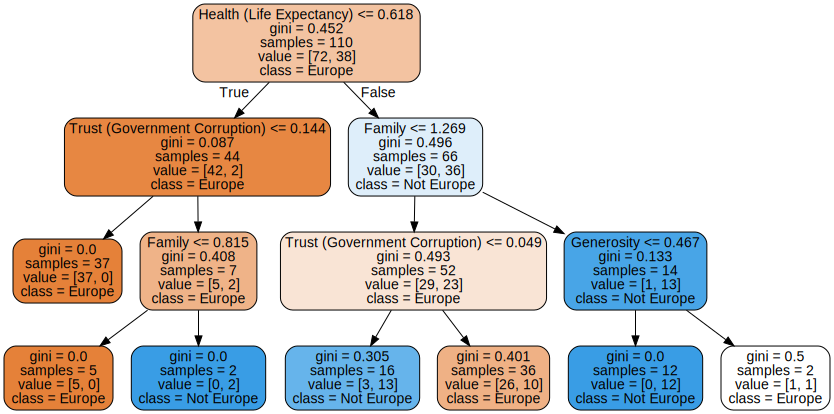

In [404]:
dec_tree = DecisionTreeClassifier(max_depth=3)
dec_tree.fit(x_train, y_train)
viz = tree.export_graphviz(dec_tree, feature_names=x_train.columns,
                           class_names=['Europe', 'Not Europe'],
                           rounded=True, filled=True)

with open("tree.dot") as f:
    dot_graph = f.read()
    graph = graphviz.Source(dot_graph)
graph

You should see something like:

![Decision Tree visualized](imgs/dt.png)

5) Visualize the decision tree of your best performing decision tree. Is there anything surprising about the splits that are most informative of this classification task?

In [201]:
# CODE

## Now write a nested for loop that loops over all the parameters and values and store the results in a data frame




In [6]:
for depths in len(9):
    for distance metric in (metric1, metric2,...):
        for weighting function in (uniform, distance weighted)
        train model
        score test data
        evaluate - calculate metrics
        store parameters and evaluation metric in data frame
print dataframe

In [418]:
depths = [2, 3, 5, 7, 9,]
criterion = ['gini', 'entropy']
max_features = [2,3,5,7]
splitter = ['best', 'random']
min_sample_l = [3,5,7,9]
min_sample_spl= [3,5,7,9]
results = []
for d in depths:
    for criteria in criterion:
        for feature in max_features:
            for split in splitter:
                for min_leave in min_sample_l:
                    for min_split in min_sample_spl:
                        dec_tree = DecisionTreeClassifier(max_depth= d, criterion = criteria, splitter = split,
                        max_features = feature, min_samples_leaf = min_leave,  min_samples_split = min_split )
                        dec_tree.fit(x_train, y_train)
                        train_pred = dec_tree.predict(x_train)
                        test_pred = dec_tree.predict(x_test)
                        # evaluate accuracy
                        train_acc = accuracy(train_pred, y_train)
                        test_acc = accuracy(test_pred, y_test)
                        result = d, criteria, feature, split, min_leave, min_split, train_acc, test_acc
                        results.append(result)        
evaluation_df = pd.DataFrame(results,columns = ['Max_depth', 'Criteria', 'Number_Features', 'Split', \
                                                'Min_Sample_leave','Min_Sample_split', 'Train_Acc', 'Test_Acc'])
evaluation_df.sort_values(by=['Test_Acc'], ascending = False)

Max_depth Criteria  Number_Features   Split  Min_Sample_leave  \
931           7  entropy                3    best                 3   
971           7  entropy                5    best                 7   
1249          9  entropy                7    best                 3   
979           7  entropy                5  random                 3   
958           7  entropy                3  random                 9   
1198          9  entropy                3    best                 9   
295           3     gini                3    best                 5   
967           7  entropy                5    best                 5   
891           7     gini                7  random                 7   
1111          9     gini                5  random                 5   
1188          9  entropy                3    best                 5   
962           7  entropy                5    best                 3   
705           5  entropy                5    best                 3   
965           7  entropy                5    best                 5   
1118          9     gini                5  random                 9   
1252          9  entropy                7    best                 5   
676           5  entropy                3    best                 5   
911           7  entropy                2    best                 9   
1254          9  entropy                7    best                 5   
482           3  entropy                7    best                 3   
1255          9  entropy                7    best                 5   
656           5  entropy                2  random                 3   
710           5  entropy                5    best                 5   
490           3  entropy                7    best                 7   
649           5  entropy                2    best                 7   
810           7     gini                3    best                 7   
646           5  entropy                2    best                 5   
364           3     gini                7    best                 9   
809           7     gini                3    best                 7   
803           7     gini                3    best                 3   
...         ...      ...              ...     ...               ...   
264           3     gini                2    best                 7   
409           3  entropy                2  random                 7   
60            2     gini                3  random                 9   
417           3  entropy                3    best                 3   
932           7  entropy                3    best                 5   
220           2  entropy                5  random                 9   
33            2     gini                3    best                 3   
1088          9     gini                5    best                 3   
731           5  entropy                5  random                 7   
945           7  entropy                3  random                 3   
1277          9  entropy                7  random                 9   
420           3  entropy                3    best                 5   
436           3  entropy                3  random                 5   
6             2     gini                2    best                 5   
385           3  entropy                2    best                 3   
51            2     gini                3  random                 3   
85            2     gini                5  random                 5   
184           2  entropy                3  random                 7   
173           2  entropy                3    best                 9   
165           2  entropy                3    best                 5   
164           2  entropy                3    best                 5   
163           2  entropy                3    best                 3   
162           2  entropy                3    best                 3   
143           2  entropy                2    best                 9   
140           2  entropy      

In [410]:
results

[(2, 'gini', 2, 'best', 3, 3, 0.7272727272727273, 0.7708333333333334),
 (2, 'gini', 2, 'best', 3, 5, 0.7636363636363637, 0.7708333333333334),
 (2, 'gini', 2, 'best', 3, 7, 0.7090909090909091, 0.7291666666666666),
 (2, 'gini', 2, 'best', 3, 9, 0.7636363636363637, 0.7708333333333334),
 (2, 'gini', 2, 'best', 5, 3, 0.7818181818181819, 0.6875),
 (2, 'gini', 2, 'best', 5, 5, 0.7636363636363637, 0.7708333333333334),
 (2, 'gini', 2, 'best', 5, 7, 0.7636363636363637, 0.7708333333333334),
 (2, 'gini', 2, 'best', 5, 9, 0.7545454545454545, 0.75),
 (2, 'gini', 2, 'best', 7, 3, 0.6545454545454545, 0.75),
 (2, 'gini', 2, 'best', 7, 5, 0.8363636363636363, 0.7708333333333334),
 (2, 'gini', 2, 'best', 7, 7, 0.6818181818181818, 0.6458333333333334),
 (2, 'gini', 2, 'best', 7, 9, 0.7272727272727273, 0.75),
 (2, 'gini', 2, 'best', 9, 3, 0.7363636363636363, 0.7916666666666666),
 (2, 'gini', 2, 'best', 9, 5, 0.7727272727272727, 0.7708333333333334),
 (2, 'gini', 2, 'best', 9, 7, 0.7, 0.75),
 (2, 'gini', 2, 'b

In [ ]:
Moving onto decision trees. The DecisionTreeClassifier constructor can take a number of parameters. You should look at all the available
criterion: string, "gini' for Gini Impurity or 'entropy' for information gain
splitter: string, "best" or 'random'
max_features: the number of features to consider when looking for the best split.
max_depth: int, the maximum depth of the tree.
min_samples_split: minimum number of samples required to split an internal node
min_samples_leaf: min number of samples required to be at a leaf node.
max_leaf_nodes: max number of leaf nodes a tree can have

# References
http://scikit-learn.org/stable/modules/neighbors.html#classification
    
http://scikit-learn.org/stable/modules/tree.html#tree